### NOTICE:
1. remember that this is only a sample copied form kaggle kernal, [the original scripit is here](https://www.kaggle.com/guyko81/allstate-claims-severity/just-an-easy-solution/comments)
2. having problem with install xgboost packages? [link](https://github.com/dmlc/xgboost/tree/master/python-package)


In [1]:
import xgboost as xgb
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm, lognorm, probplot
import matplotlib.mlab as mlab
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) #display all columns
%matplotlib inline

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

features = [x for x in train.columns if x not in ['id','loss']]
cat_features = [x for x in train.columns if 'cat' in x]
num_features = [x for x in train.columns if 'cont' in x]

print('train size is {}, test size is {}'.format(train.shape,test.shape) )

train size is (188318, 132), test size is (125546, 131)


In [9]:
cat_features

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cat19',
 'cat20',
 'cat21',
 'cat22',
 'cat23',
 'cat24',
 'cat25',
 'cat26',
 'cat27',
 'cat28',
 'cat29',
 'cat30',
 'cat31',
 'cat32',
 'cat33',
 'cat34',
 'cat35',
 'cat36',
 'cat37',
 'cat38',
 'cat39',
 'cat40',
 'cat41',
 'cat42',
 'cat43',
 'cat44',
 'cat45',
 'cat46',
 'cat47',
 'cat48',
 'cat49',
 'cat50',
 'cat51',
 'cat52',
 'cat53',
 'cat54',
 'cat55',
 'cat56',
 'cat57',
 'cat58',
 'cat59',
 'cat60',
 'cat61',
 'cat62',
 'cat63',
 'cat64',
 'cat65',
 'cat66',
 'cat67',
 'cat68',
 'cat69',
 'cat70',
 'cat71',
 'cat72',
 'cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101

In [3]:
print(train.skew())

id       -0.002155
cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      3.794958
dtype: float64


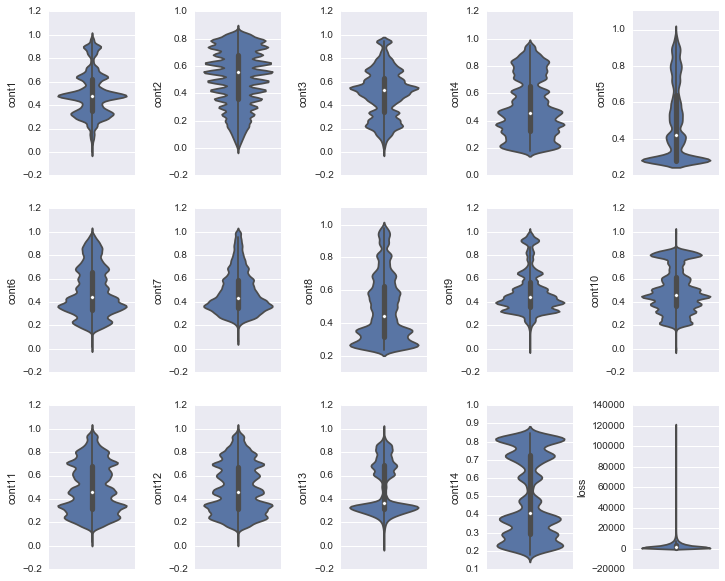

In [21]:
# seaborn.violinplot
violin_data = pd.concat((train[num_features],train['loss']),axis=1)
names = violin_data.columns

fig_num,ax=plt.subplots(nrows=3,ncols=5,figsize=(12,10))
plt.subplots_adjust(wspace=0.7)
for row in range(3):
    for col in range(5):
        sns.violinplot(y=names[row*5+col],data = violin_data,ax=ax[row,col])


In [5]:
# use stats.shapiro to see whether the distribution is normal
shapiro_stats = []
for i in range(len(num_features)):
    shapiro_stat =  shapiro(train[num_features].iloc[:,i])[1]
    shapiro_stats.append(shapiro_stat)
print(shapiro_stats)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


- none of features follow normal distribution

if the loss follows a log-normal distribution

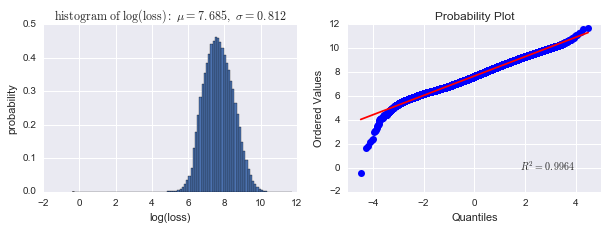

In [6]:
train['log_loss'] = np.log(train['loss']) # https://www.zhihu.com/question/22012482
f,(fig1,fig2) = plt.subplots(1,2,figsize = (10,3))
fig1.hist(np.log(train['loss']),bins=100,normed = 1)
fig1.set_xlabel('log(loss)')
fig1.set_ylabel('probability')
(mu , sigma) = norm.fit(train['log_loss'])
fig1.set_title(r'$\mathrm{histogram\ of\ log(loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

probplot(np.log(train['loss']),plot=fig2)

plt.show()

In [13]:
uniq_var = []
for i in cat_features:
    uniq_var.append(len(set(train[i])))
print(uniq_var)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 7, 8, 7, 5, 7, 5, 8, 7, 5, 16, 15, 19, 9, 13, 17, 20, 17, 20, 11, 84, 131, 16, 51, 61, 19, 23, 326]


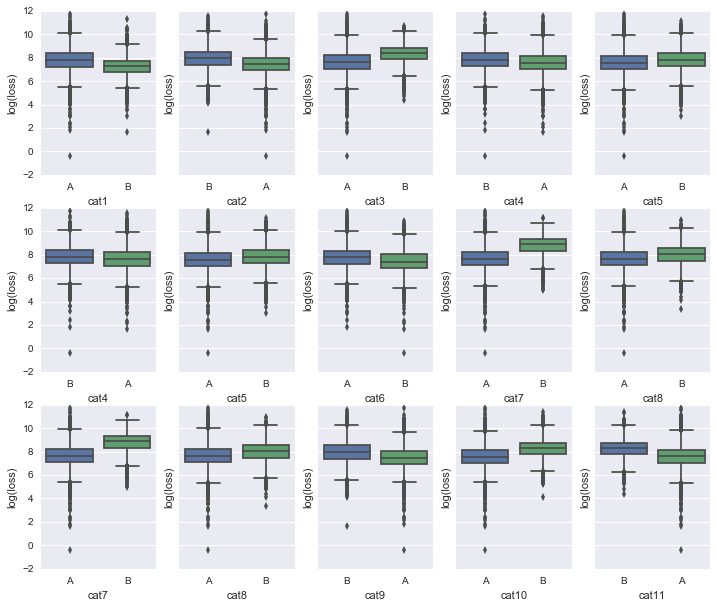

In [29]:
train['log(loss)'] = np.log(train['loss'])
fig_cat_top15,ax = plt.subplots(nrows=3,ncols=5,figsize=(12,10),sharey=True)
for row in range(3):
    for col in range(5):
        sns.boxplot(train[cat_features[row*3+col]],train['log(loss)'],ax=ax[row,col])
        

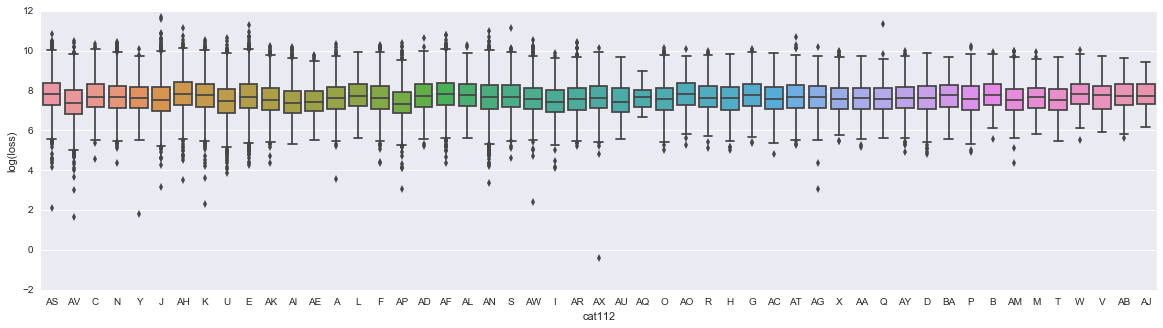

In [42]:
# satets boxplot(having 51 variables)
plt.rc('figure',figsize=(20,5))
sns.boxplot(train[cat_features[-5]],train['log(loss)'])

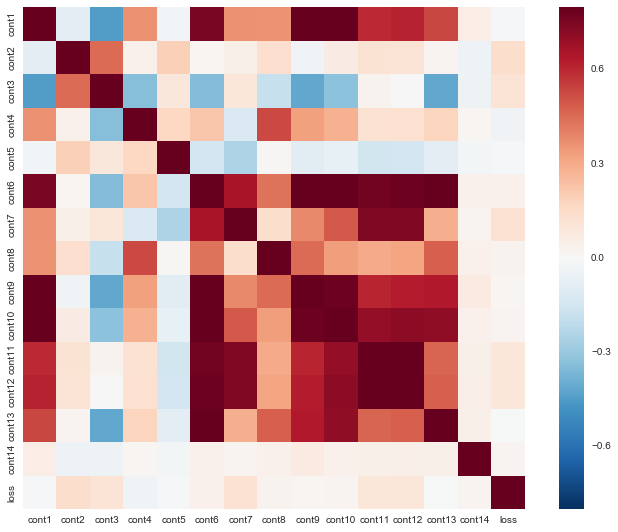

In [140]:
cor_mat_data = violin_data
fig,ax = plt.subplots(figsize=(12,9))
sns.heatmap(cor_mat_data.corr(),vmax=.8, square=True)

In [113]:
# transfrom from cat to num variables
# for i in range(len(cat_features)):
#    train_test[cat_features[i]] = train_test[cat_features[i]].astype('category').cat.codes


In [99]:
train_test = pd.concat((train[features],test[features]),axis=0).reset_index(drop=1)

train_test_cat_encoded =pd.get_dummies(train_test[cat_features])

In [100]:
train_test_cat_encoded.shape

(313864, 1176)

In [101]:
# seperate our data into test & train  again
train_test_encoded = pd.concat((train_test_cat_encoded,train_test[num_features]),axis=1)

train_x = train_test_encoded.iloc[:nrow_train,:]
test_x = train_test_encoded.iloc[nrow_train:,:]

In [102]:
train_x

,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat4_A,cat4_B,cat5_A,cat5_B,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
5,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792
6,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931
7,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416
8,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191
9,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523


- build up the xgboost model

In [107]:
xgbmat = xgb.DMatrix(train_x,train['log_loss'])

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3}

num_rounds = 2000

bst = xgb.train(params,xgbmat,num_rounds)
pred = bst.predict(xgb.DMatrix(test_x))

In [108]:
loss = pd.DataFrame(np.e**pred)
id = test['id']
rslt = pd.DataFrame({'id':test['id'],'loss':np.e**pred})

In [109]:
rslt

,id,loss
0,4,1454.398193
1,6,1898.811279
2,9,9065.073242
3,12,5718.464355
4,15,825.752441
5,17,2247.246338
6,21,2363.466064
7,28,867.265259
8,32,2228.727051
9,43,3058.122070


In [110]:
rslt.to_csv('result3_2000run_encoded4cats.csv',index=0)

- following is a little example using get_dummies to do one hot enc

In [59]:
tst = np.transpose(pd.DataFrame([['A','B','B'],['A','B','C']]))
tst

,0,1
0,A,A
1,B,B
2,B,C


In [60]:
pd.get_dummies(tst)

,0_A,0_B,1_A,1_B,1_C
0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0
